In [1]:

import numpy as np
from skimage.feature import corner_harris, peak_local_max


def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1, k = 0.2)
    coords = peak_local_max(h, min_distance=30)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2 Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """

    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

<>:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?


/var/folders/lf/lddj8h6s3m3g8fkfp14cq4bw0000gn/T/ipykernel_79071/2160995721.py:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [2]:
from scipy.spatial import Delaunay
import json
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon, polygon2mask
from scipy.interpolate import griddata
import skimage.io as io
import skimage as sk
from scipy import interpolate

In [3]:
def normalize_image(im):
    return (im - np.amin(im)) / (np.amax(im) - np.amin(im))

In [4]:
im1 = io.imread("images/stadium1.jpg")
# im1_gray = sk.color.rgb2gray(im1)
im1.shape

(4000, 6000, 3)

In [5]:

def calculate_suppression_radius(c_robust, h, coords, coord):
    coordsTransposed = coords.T
    def filterPoints(coordOther):
        if h[coordsTransposed[coord][0], coordsTransposed[coord][1]] < c_robust * h[coordsTransposed[coordOther][0], coordsTransposed[coordOther][1]]:
            return True
        else:
            return False
    # coordsIndexFiltered = list(filter(filterPoints, np.arange(len(coordsTransposed))))
    # coordsFiltered = coordsTransposed[coordsIndexFiltered]
    # print(coordsIndexFiltered)
    # print(coordsFiltered.shape)
    dists = dist2(coordsTransposed, coordsTransposed[coord].reshape((1, 2)))
    dists = dists.flatten()
    dists = [ dists[i] for i in range(len(dists)) if filterPoints(i)]
    if len(dists) == 0:
        min_dist = 0
    else:
        min_dist = np.min(dists)
    return min_dist

def non_maximal_suppression(im, targetNumber):
    c = 0.9
    h, coords = get_harris_corners(im) 
    coordsTransposed = coords.T
    radius_list = [ [calculate_suppression_radius(c, h, coords, coord), coord] for coord in range(len(coords[1]))]
    radius_list.sort( key=lambda x: x[0], reverse=True)
    print(np.array(radius_list).shape)
    if len(radius_list) > targetNumber:
        radius_list = radius_list[:targetNumber]
    result = [ list(coordsTransposed[radius[1]]) for radius in radius_list]

    return result

In [6]:
room1 = io.imread("images/room1.png")[:, :, :3]
room1_gray = sk.color.rgb2gray(room1)

In [7]:
room1_h, room1_coords = get_harris_corners(room1_gray)

In [8]:
room1_coords = room1_coords.T

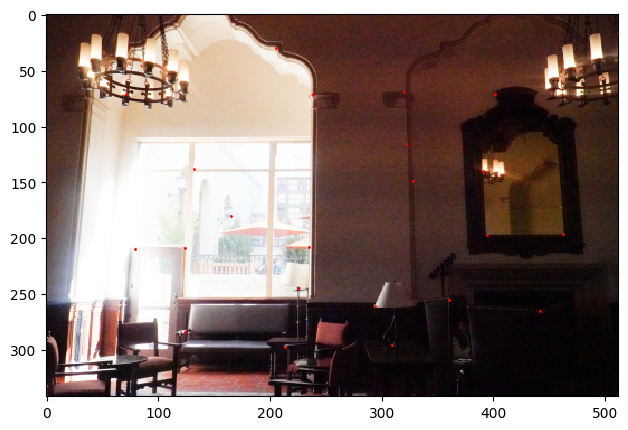

In [9]:
io.imshow(normalize_image(room1)) 
plt.scatter(room1_coords[:,1], room1_coords[:,0], s=1, c='r')

In [10]:
room1_anms_coords = non_maximal_suppression(room1_gray, 100)

(22, 2)


In [37]:
ihouse1 = io.imread("images/ihouse1.png")[:, :, :3]
ihouse1_gray = sk.color.rgb2gray(ihouse1)

In [38]:
ihouse1_h, ihouse1_coords = get_harris_corners(ihouse1_gray)
ihouse1_coords = ihouse1_coords.T

In [40]:
ihouse1_self_coords = non_maximal_suppression(ihouse1_gray, 100)
ihouse1_self_coords = np.array(ihouse1_self_coords)

(26, 2)


In [41]:
ihouse2 = io.imread("images/ihouse2.png")[:, :, :3]
ihouse2_gray = sk.color.rgb2gray(ihouse2)

In [42]:
ihouse2_self_coords = non_maximal_suppression(ihouse2_gray, 100)
ihouse2_self_coords = np.array(ihouse2_self_coords)

(27, 2)


In [43]:
ihouse1_self_coords = np.array(ihouse1_self_coords)

Feature Descriptor Extraction

In [45]:
import cv2
import scipy.signal

In [46]:
def samplePatch(img, points, patch_size):
    patches = []
    for point in points:
        patch = img[point[0] - patch_size:point[0] + patch_size, point[1] - patch_size:point[1] + patch_size]

        patchDownsampled = sk.transform.resize(patch, (8, 8), anti_aliasing=True)
        patchDownsampledNormalized = (patchDownsampled- np.mean(patchDownsampled)) / np.std(patchDownsampled)
        patches.append((patchDownsampledNormalized, point))
    return patches 

In [47]:
patches = samplePatch(ihouse1_gray, ihouse1_self_coords, 20)


In [48]:
def ssd(im1, im2):
  return np.sum((im1 - im2)**2)

In [49]:
def compareDescriptors(im1, im2, im1_points, im2_points):
    patches1 = samplePatch(im1, im1_points, 20)
    patches2 = samplePatch(im2, im2_points, 20)
    featureMap = {}
    for i in range(len(patches1)):
        closest = min(patches2, key=lambda x: ssd(patches1[i][0], x[0]))
        closestDist = ssd(patches1[i][0], closest[0]) 
        patches2_without_closest = [patch for patch in patches2 if not np.array_equal(patch[0], closest[0])]
        second_closest = min(patches2_without_closest, key=lambda x: ssd(patches1[i][0], x[0]))
        second_closestDist = ssd(patches1[i][0], second_closest[0])
        ratio = closestDist / second_closestDist 
        if ratio < 0.4:  
            featureMap[tuple(closest[1])] = [patches1[i][1], ratio]
    featureMap = dict(sorted(featureMap.items(), key=lambda x: x[1][1]))
    for key in featureMap:
        featureMap[key] = featureMap[key][0]
    return featureMap   

In [50]:
ihouse2 = io.imread("images/ihouse2.png")[:, :, :3]
ihouse2_gray = sk.color.rgb2gray(ihouse2)

In [51]:
ihouse2_coords = non_maximal_suppression(ihouse2_gray, 100) 

(27, 2)


In [52]:
ihouse1_patches = samplePatch(ihouse1_gray, ihouse1_self_coords, 20) 
ihouse2_patches = samplePatch(ihouse2_gray, ihouse2_self_coords, 20) 

In [53]:
ihouse_feature_map = compareDescriptors(ihouse1_gray, ihouse2_gray, ihouse1_self_coords, ihouse2_self_coords)

In [54]:
ihouse2_features = np.array(list(ihouse_feature_map.keys()))
ihouse1_features = np.array(list(ihouse_feature_map.values()))

RANSAC

In [57]:
def computeH(im1_points, im2_points):
  A = []
  B = []
  for i in range(len(im1_points)):
    p1 = im1_points[i]
    p2 = im2_points[i] 
    A.append([p1[0], p1[1], 1, 0, 0, 0, -p1[0] * p2[0], -p1[1] * p2[0]])
    A.append([0, 0, 0, p1[0], p1[1], 1, -p1[0] * p2[1], -p1[1] * p2[1]])
    B.append(p2[0])
    B.append(p2[1])
  A = np.asarray(A)
  B = np.asarray(B)
  H_flatten = np.linalg.lstsq(A, B)[0]
  H_flatten = np.asarray(H_flatten.tolist() + [1])
  return np.reshape(H_flatten, (3, 3))

In [58]:
def normalize(im):
    return (im - np.amin(im)) / (np.amax(im) - np.amin(im))

In [62]:
h = computeH(ihouse1_features, ihouse2_features)

/var/folders/lf/lddj8h6s3m3g8fkfp14cq4bw0000gn/T/ipykernel_79071/628019653.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_flatten = np.linalg.lstsq(A, B)[0]


In [65]:
import cv2 

In [66]:
def ransac(im1, im2, num_iterations=1000, threshold=50):
    im1_coords = non_maximal_suppression(im1, 100)
    im2_coords = non_maximal_suppression(im2, 100) 
    feature_map = compareDescriptors(im1, im2, im1_coords, im2_coords)
    feature_map = np.array(list(feature_map.items())) 
    im1_features = feature_map[:, 1]
    im2_features = feature_map[:, 0] 
    if len(feature_map) < 4: 
        raise Exception("Not enough features")
    selected_im1_points = np.array([im1_features[key] for key in range(4)])
    selected_im2_points = np.array([im2_features[key] for key in range(4)]) 
    assert selected_im1_points.shape == selected_im2_points.shape
    best_inliers = []
    for i in range(num_iterations):
        homography_matrix = cv2.findHomography(selected_im1_points, selected_im2_points)[0]
        points_with_dists = []
        inliers = []
        for j in range(len(im1_features)):
            point = np.array([im2_features[j][1], im2_features[j][0], 1])
            warped_point = homography_matrix @ point  # Correct matrix multiplication order
            warped_point /= warped_point[2]  # Normalize by the homogeneous coordinate
            warped_point = warped_point[:2]
            dist = np.linalg.norm(warped_point - im1_features[j])
            if dist < threshold:
                inliers.append([point[:2], im1_features[j], dist])
            points_with_dists.append([point[:2], im1_features[j], dist])
        if len(inliers) < 4:
            inliers =  sorted(points_with_dists, key=lambda x: x[2])[:4]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
        # feature_map = np.array([ [point[1], point[0]] for point in best_inliers])
        # im1_features = feature_map[:, 0]
        # im2_features = feature_map[:, 1] 
        # selected_im1_points = np.array([im1_features[key] for key in range(4)])
        # selected_im2_points = np.array([im2_features[key] for key in range(4)]) 
    #     im1_features = feature_map[:, 0]
    #     im2_features = feature_map[:, 1]
    #     selected_im1_points = np.array([im1_features[key] for key in range(4)])
    #     selected_im2_points = np.array([im2_features[key] for key in range(4)])
    #     if len(inliers) > len(best_inliers):
    #         best_inliers = inliers
    #     warped_im1_points = np.array(warpPoints(im1_features, homography_matrix))  
    #     points_with_dists = [ [selected_im1_points[i].tolist(), selected_im2_points[i].tolist(), np.linalg.norm(warped_im1_points[i] - selected_im2_points[i])] for i in range(len(selected_im2_points))]
    #     inliers = [np.array(point[0][:2]) for point in points_with_dists if point[2] < threshold]
    #     if len(inliers) < 4:
    #         inliers = sorted(points_with_dists, key=lambda x: x[2])[:4]
    #     if len(inliers) > len(best_inliers):
    #         best_inliers = inliers
    #     feature_map = np.array([ [point[0], point[1]] for point in inliers])
    #     im1_features = feature_map[:, 0]
    #     im2_features = feature_map[:, 1]
    #     selected_im1_points = np.array([im1_features[key] for key in range(4)]) 
    #     selected_im2_points = np.array([im2_features[key] for key in range(4)])
    homography_matrix = cv2.findHomography(np.array([point[0] for point in best_inliers]), np.array([point[1] for point in best_inliers]))[0]
    print(points_with_dists)
    return homography_matrix

In [69]:
num_points = 10

# Define the size of the image (width and height)
image_width = 640
image_height = 480

# Create random src points as pixel coordinates within the image size
src_points = np.column_stack((np.random.randint(0, image_width, size=num_points),
                              np.random.randint(0, image_height, size=num_points)))

# Generate random RGB color values for each point
src_colors = np.random.randint(0, 256, size=(num_points, 3), dtype=np.uint8)

# Combine src points and src colors into a single array
src_data = np.hstack((src_points, src_colors))

# Create a blank canvas with the specified image dimensions
image_src = np.zeros((image_height, image_width, 3), dtype=np.uint8)

# Fill the image with src_data
for point_data in src_data:
    x, y, r, g, b = point_data
    image_src[y, x] = [r, g, b]

translation_x = 20
translation_y = 30

# Apply the transformation to src_points to generate dst_points
dst_points = src_points + np.array([translation_x, translation_y])

# Create a blank canvas for dst_image
dst_image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
print(dst_points.shape == src_points.shape)

# Fill dst_image with dst_points and the same RGB colors as src_image
for src_point, dst_point in zip(src_points, dst_points):
    x_src, y_src = src_point 
    x_dst, y_dst = dst_point
    dst_image[y_dst, x_dst] = image_src[y_src, x_src] 

True


In [76]:
painting1 = io.imread("images/painting.png")[:, :, :3]
painting1_gray = sk.color.rgb2gray(painting1)
painting2 = io.imread("images/painting2.png")[:, :, :3]
painting2_gray = sk.color.rgb2gray(painting2)

In [77]:
painting1_coords = non_maximal_suppression(painting1_gray, 100)
painting2_coords = non_maximal_suppression(painting2_gray, 100)

(28, 2)
(33, 2)


In [78]:
painting_feature_map = compareDescriptors(painting1_gray, painting2_gray, painting1_coords, painting2_coords)
painting_feature_list = np.array([ [key[0], key[1], value[0], value[1] ] for key, value in ihouse_feature_map.items()])

In [102]:
painting1_features = painting_feature_list[:, :2]
painting2_features = painting_feature_list[:, 2:]
io.imshow(normalize_image(painting1)) 
plt.scatter(painting1_features[:,1], painting2_features[:,0], s=1, c='r')

In [87]:
import math

In [88]:
def normalize(arr):
    ws = arr[:,2].reshape(len(arr), 1)
    return (arr/ws)[:,:2]

def new_canvas_ranges(orig_img, H):
    h, w = orig_img.shape[:2]
    topleft_o = np.array([0,0,1])
    topright_o = np.array([w,0,1])
    botleft_o = np.array([0,h,1])
    botright_o = np.array([w,h,1])
    
    topleft_n = topleft_o @ H.T
    topleft_n /= topleft_n[2]
    
    
    topright_n = topright_o @ H.T
    topright_n /= topright_n[2]
    
    botleft_n = botleft_o @ H.T
    botleft_n /= botleft_n[2]
    
    botright_n = botright_o @ H.T
    botright_n /= botright_n[2]
    
    max_x = math.ceil(max(topright_n[0], botright_n[0]))
    min_x = math.floor(min(topleft_n[0], botleft_n[0]))
    width = max_x - min_x
    
    max_y = math.ceil(max(botleft_n[1], botright_n[1]))
    min_y = math.floor(min(topleft_n[1], topright_n[1]))
    
    height = max_y - min_y
    
    return np.arange(min_x, max_x, 1), np.arange(min_y, max_y, 1), np.array([height, width])

def warp_image(orig_img, H, method):
    
    
    
    def convert_to_list_of_coords(xs, ys):
        gridx, gridy = np.meshgrid(xs, ys)
        stacked = np.stack((gridx, gridy, np.ones(gridx.shape)), axis = 2)
        flat_stax = stacked.reshape((gridx.size, 3))
        return flat_stax
        
    
    H_inv = np.linalg.inv(H)
    
    new_xrange, new_yrange, new_shape = new_canvas_ranges(orig_img, H)
    new_coords = convert_to_list_of_coords(new_xrange, new_yrange)
    
    inv_warp_x, inv_warp_y = normalize(new_coords @ H_inv.T).T
    
    old_coords = convert_to_list_of_coords(np.arange(0, orig_img.shape[1], 1), np.arange(0,orig_img.shape[0],1))
    old_xs, old_ys, _ = old_coords.T
    
    
    
    list_of_colors = []
    # iterate through the colors
    for c in range(orig_img.shape[2]):
        this_color = interpolate.griddata((old_xs, old_ys), orig_img[:,:,c].flatten(), (inv_warp_x, inv_warp_y), method=method, fill_value=0)
        print(f"done with color {c}")
        list_of_colors.append(this_color.reshape(new_shape))
    
    return np.stack(list_of_colors, axis = 2), new_xrange[0], new_yrange[0]
    

def warp_image_and_get_midpoints(orig_img, src_pts, dst_pts, method = 'nearest'):
    H = computeH(src_pts, dst_pts)
    midpoint_orig = np.hstack((np.mean(src_pts, axis=0), [1]))
    midpoint_warped = midpoint_orig @ H.T
    midpoint_warped /= midpoint_warped[2]
    
    midpoint_dest = np.mean(dst_pts, axis=0)
    
    warped, img_start_x, img_start_y = warp_image(orig_img, H, method)
    
    top_left_corner = np.array([img_start_x, img_start_y])
    midpoint_warped = midpoint_warped[:2] - top_left_corner
    
    return warped, midpoint_warped, midpoint_dest

In [89]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktr

def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape

    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, (dscale, dscale, 1))
    else:
        im2 = sktr.rescale(im2, (1./dscale, 1./dscale, 1))
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2 